# Notebook for analyzing tagged vs untagged cells

In [1]:
# Imports:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import math
import psycopg2
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook
import nose as nose

from scipy import signal 

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
#for access to google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

import scipy as scipy
import pycircstat as pycircstat

### Define cutoffs

In [2]:
# taking the 95th percentiles for now 
grid_cutoff =  0.2980
mvl_cutoff = 0.1713
speed_cutoff = 0.1907
spatial_info_cutoff = 0.8204
border_cutoff = 0.5007
rate_cutoff = 0.2 

# Retrieve and cleanup data 


In [45]:
arch_all = pd.read_pickle("arch_all.pkl")
arch_all = arch_all.dropna(subset=['calbindin_bnt'])#This will drop cells that have important data missing (quality control)
drop_subgroup= ['session_ts','session_name','cluster_no','tetrode_no']
arch_all = arch_all.drop_duplicates(subset=drop_subgroup, keep='first', inplace=False)

#Note that the step above is not needed for this particular .pkl file because the duplicates have already been removed, but it is an extremely useful quality control and sanity check when working with. 
#Also, if you reload the pkl without restarting the kernel, it is possible that you will accidentally double the dataset and this line of code will become helpful. 
#The logic of the above line of code is that it will drop cells that have identical values for session name, cluster number, tetrode number and session_ts (precise date and time of the session). The combination of these things provides a 
#unique ID for a given cell, so if appears twice, we know something is wrong and to remove all but the first instance. If you want to prove to yourself that the code snippet works, you could eliminate all but
#'tetrode_no' and check the length. The length should be 4 because it takes the first instance of each tetrode and drops all other cells because we only have 4 tetrodes.

### Take 1 local field potential 

In [46]:
#We record multiple lfps per session and some scores for each lfp. This section picks just one of those for the plotting (hence the name '..._single') 
new_column = []
for i in range(len(arch_all)):
    mj = arch_all.theta_mean_phase_bnt.iloc[i]
    if np.isscalar(mj)== True:
        new_column.append(mj) 
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
arch_all['theta_mean_phase_bnt_single'] = new_column

new_column = []
for i in range(len(arch_all)):
    mj = arch_all.theta_strength_bnt.iloc[i]
    if np.isscalar(mj) == True:
        new_column.append(mj)
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
arch_all['theta_strength_bnt_single'] = new_column

new_column = []
for i in range(len(arch_all)):
    mj = arch_all.calbindin_dist_bnt.iloc[i]
    if np.isscalar(mj) == True:
        new_column.append(mj)
    else: 
        mp = mj[0]
        new_column.append(mp)

# now overwrite previous column:
arch_all['calbindin_dist_bnt_single'] = new_column

## Get total number of tagged cells
This will retrieve all the cells that were tagged in the dataset (see text for criteria)

In [47]:
cells = arch_all[(arch_all.label == 'inhibited')].copy()
inhib_cells = arch_all[(arch_all.label == 'inhibited')].copy()
label = 'Tagged arch\nn={}'.format(len(cells))

In [48]:
print('There are {} in this filtered dataframe. Label: {}'.format(len(cells),label))

There are 75 in this filtered dataframe. Label: Tagged arch
n=75


## Draw stacked bar chart
The following sections draw the stacked bar charts used in Figure 3, first for the tagged cells ("arch_all") and then for the remaining cells. The bar charts have a dark color for cells that fall into one category ("pure") and a lighter color for cells that fall into multiple categories ("mix"). The percentages above the bars give the total number. Note that all "mix" cells are counted in at least 2 categories and therefore the percentages will not sum to 100%. We prefered this represenation of the data to a pie chart (or similar) with different slices for all possible conjunctions (grid x HD, speed X border etc.) because the number of possible combinations is large and makes for a complicated figure.

In [49]:
gridc = cells[cells.grid_score_bnt > grid_cutoff]
hdc = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt>0.6)]#note additional criteria for stability
speedc = cells[cells.speedscore_bnt > speed_cutoff]
borderc = cells[cells.borderscore_bnt > border_cutoff]

unclas = cells[(~cells.index.isin(gridc.index)) &\
               (~cells.index.isin(hdc.index))  &\
               (~cells.index.isin(speedc.index))  &\
               (~cells.index.isin(borderc.index))]


In [50]:
# find all the class labels for "pure cells" by
# finding non-overlap within indices of other cell classes

pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [51]:
all_len = len(cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
#unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)
frac_unclas = unclas_len/all_len


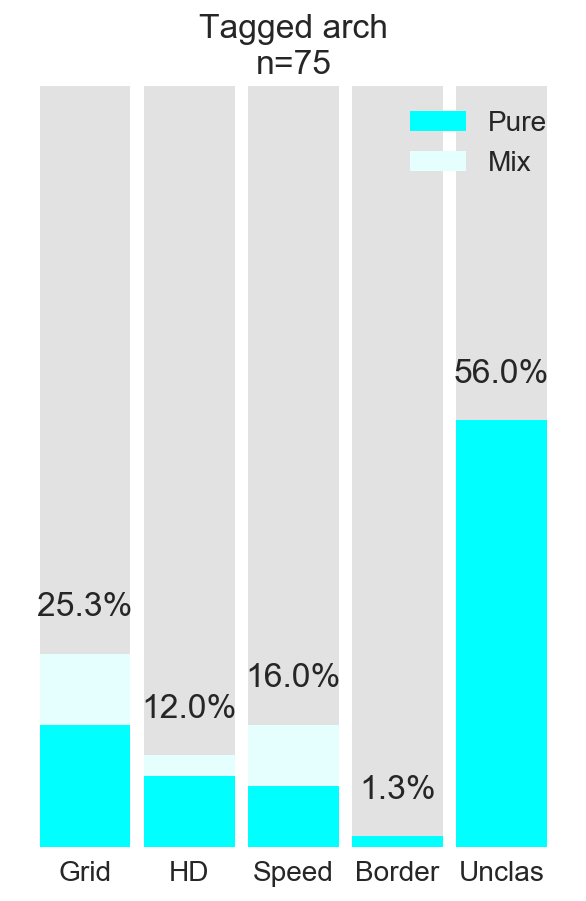

(0.16, 0.09333333333333334, 0.08, 0.013333333333333334, 0.56)


In [52]:
# grid, hd, speed, border, unclassified
sns.set(font_scale=1.4,style='white')
seq_col_brew = sns.color_palette(sns.light_palette("cyan",5))
sns.set_palette(seq_col_brew)

plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=seq_col_brew[4])
p2 = plt.bar(ind, mix, width, color=seq_col_brew[0], bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\tagged_stacked_bar.svg', format='svg', dpi=1000)
plt.show()
print(pure)

## Now make the same stacked bar but for all other cells

In [53]:
non_inhib_cells = arch_all[(arch_all.label != 'inhibited')].copy()# retrieves all cells that were not tagged
non_inhib_cells = non_inhib_cells[non_inhib_cells.artefact ==0]
label = 'untagged \nn={}'.format(len(non_inhib_cells))#and labels them
print(len(non_inhib_cells))

503


In [54]:
gridc = non_inhib_cells[non_inhib_cells.grid_score_bnt > grid_cutoff]
hdc = non_inhib_cells[(non_inhib_cells.tc_stats_mvl_bnt > mvl_cutoff)&(non_inhib_cells.angular_stability_bnt>0.6)]# plus stability
speedc = non_inhib_cells[non_inhib_cells.speedscore_bnt > speed_cutoff]
borderc = non_inhib_cells[non_inhib_cells.borderscore_bnt > border_cutoff]

unclas = non_inhib_cells[(~non_inhib_cells.index.isin(gridc.index)) &\
               (~non_inhib_cells.index.isin(hdc.index))  &\
               (~non_inhib_cells.index.isin(speedc.index))  &\
               (~non_inhib_cells.index.isin(borderc.index))]

In [55]:
pure_gridc = gridc[(~gridc.index.isin(hdc.index)) & (~gridc.index.isin(speedc.index)) & (~gridc.index.isin(borderc.index))]
pure_hdc = hdc[(~hdc.index.isin(gridc.index)) & (~hdc.index.isin(speedc.index)) & (~hdc.index.isin(borderc.index))]
pure_borderc = borderc[(~borderc.index.isin(gridc.index)) & (~borderc.index.isin(speedc.index)) & (~borderc.index.isin(hdc.index))]
pure_speedc = speedc[(~speedc.index.isin(gridc.index)) & (~speedc.index.isin(borderc.index)) & (~speedc.index.isin(hdc.index))]

In [56]:
all_len = len(non_inhib_cells)
# Grid
grid_len = len(gridc)
frac_grid = grid_len/all_len
pure_grid_len = len(pure_gridc)
mix_grid_len = grid_len-pure_grid_len

# HD
hd_len = len(hdc)
frac_hd = hd_len/all_len
pure_hd_len = len(pure_hdc)
mix_hd_len = hd_len-pure_hd_len

# Speed
speed_len = len(speedc)
frac_speed = speed_len/all_len
pure_speed_len = len(pure_speedc)
mix_speed_len = speed_len-pure_speed_len

# Border
border_len = len(borderc)
frac_border = border_len/all_len
pure_border_len = len(pure_borderc)
mix_border_len = border_len-pure_border_len

# Rest
#unstable_HD = cells[(cells.tc_stats_mvl_bnt > mvl_cutoff)&(cells.angular_stability_bnt <= 0.6)]#must also add unstable head direction cells
unclas_len = len(unclas)
frac_unclas = unclas_len/all_len

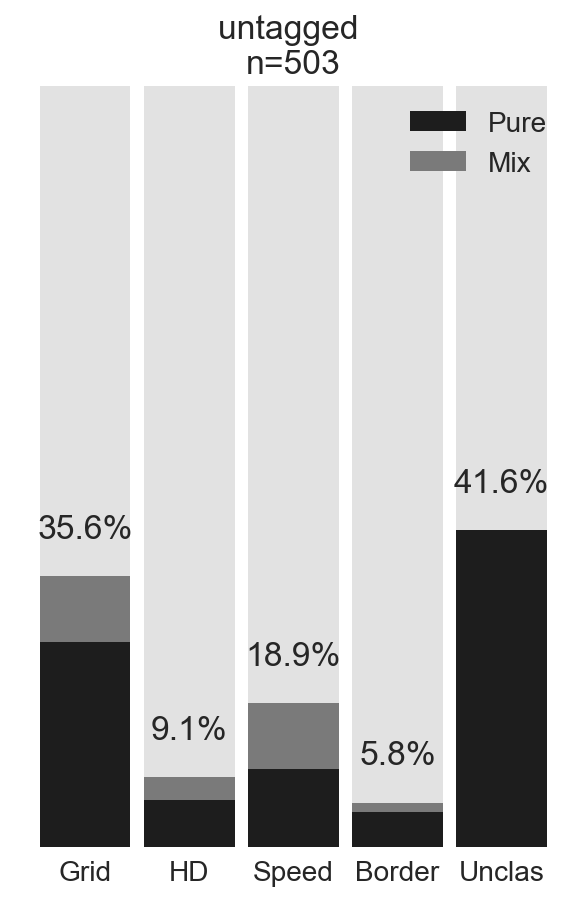

(0.268389662027833, 0.061630218687872766, 0.10139165009940358, 0.04572564612326044, 0.415506958250497)


In [57]:
# grid, hd, speed, border, unclassified

colors = cm.Greys

sns.set(font_scale=1.4,style='white')
plt.figure(figsize=(5,7))


N = 5
pure = (pure_grid_len/all_len, pure_hd_len/all_len, pure_speed_len/all_len, pure_border_len/all_len, unclas_len/all_len)
mix = (mix_grid_len/all_len, mix_hd_len/all_len, mix_speed_len/all_len, mix_border_len/all_len,0)

rest = ((all_len-(pure_grid_len+mix_grid_len))/all_len,\
        (all_len-(pure_hd_len+mix_hd_len))/all_len,\
        (all_len-(pure_speed_len+mix_speed_len))/all_len,\
        (all_len-(pure_border_len+mix_border_len))/all_len,\
        (all_len-unclas_len)/all_len)

ind = np.arange(N)    # the x locations for the groups
width = 0.87       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pure, width, color=colors(0.9))
p2 = plt.bar(ind, mix, width, color=colors(0.6), bottom=pure)
p3 = plt.bar(ind, rest,width,color=plt.cm.Greys(0.2),bottom=[x+y for x,y in zip(pure,mix)])

labels = [frac_grid,frac_hd,frac_speed,frac_border,frac_unclas]
for i in ind:
    # write label:
    plt.text(i,labels[i]+.05,'{:.1f}%'.format(labels[i]*100),horizontalalignment='center')

#plt.ylabel('Fraction')
plt.xticks(ind, ('Grid', 'HD', 'Speed', 'Border','Unclas'))
plt.gca().get_yaxis().set_ticks([])

plt.legend((p1[0], p2[0]), ('Pure', 'Mix'))
plt.ylim(0,1)
plt.title(label)
sns.despine(left=True,bottom=True)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\untagged_stacked_bar.svg', format='svg', dpi=1000)
plt.show()
print(pure)#percentages of pure cells are printed below the graph. You can use these values to get the relative amounts
#of pure and mixed cells

## Compare scores between tagged and untagged populations
The following section will compare the functional properties between tagged and untagged cells.The code is essentially repeated for each variable. The only change is what is being compared. As a second check, we also compared the scores of cells that crossed threshold for inclusion in a cell class. 


### Look at grid score 

In [58]:
from scipy.stats import mannwhitneyu
ab = inhib_cells.grid_score_bnt
ab = ab.dropna()
new_list = [x+1 for x in ab]
ac = non_inhib_cells.grid_score_bnt
ac = ac.dropna()
new_list2 = [x+1 for x in ac]
scipy.stats.mannwhitneyu(new_list, new_list2, alternative = 'two-sided')

MannwhitneyuResult(statistic=14225.0, pvalue=0.0037210232849107525)

In [59]:
scipy.stats.mannwhitneyu(ab, ac, alternative = 'two-sided')

MannwhitneyuResult(statistic=14225.0, pvalue=0.0037210232849107525)

In [60]:
inhib_grid_cells = inhib_cells[inhib_cells.grid_score_bnt > grid_cutoff]
non_inhib_grid_cells = non_inhib_cells[non_inhib_cells.grid_score_bnt > grid_cutoff]
scipy.stats.mannwhitneyu(inhib_grid_cells.grid_score_bnt, non_inhib_grid_cells.grid_score_bnt, alternative = "two-sided")

MannwhitneyuResult(statistic=1786.0, pvalue=0.72040705154842888)

### Look at speed score

In [61]:
scipy.stats.mannwhitneyu(inhib_cells.speedscore_bnt, non_inhib_cells.speedscore_bnt)

MannwhitneyuResult(statistic=18307.0, pvalue=0.34040163687881936)

In [62]:
inhib_speed_cells = inhib_cells[inhib_cells.speedscore_bnt > speed_cutoff]
non_inhib_speed_cells = non_inhib_cells[non_inhib_cells.speedscore_bnt > speed_cutoff]
scipy.stats.mannwhitneyu(inhib_speed_cells.speedscore_bnt, non_inhib_speed_cells.speedscore_bnt, alternative = "two-sided")

MannwhitneyuResult(statistic=461.0, pvalue=0.2840955962642)

### look at directional tuning

In [63]:
scipy.stats.mannwhitneyu(inhib_cells.tc_stats_mvl_bnt, non_inhib_cells.tc_stats_mvl_bnt,alternative = "two-sided")

MannwhitneyuResult(statistic=22869.0, pvalue=0.0029852165760421126)

In [64]:
inhib_hdc_cells = inhib_cells[(inhib_cells.tc_stats_mvl_bnt > mvl_cutoff)&(inhib_cells.angular_stability_bnt>0.6)]
non_inhib_hdc_cells = non_inhib_cells[(non_inhib_cells.tc_stats_mvl_bnt > mvl_cutoff)&(non_inhib_cells.angular_stability_bnt>0.6)]
scipy.stats.mannwhitneyu(inhib_hdc_cells.tc_stats_mvl_bnt, non_inhib_hdc_cells.tc_stats_mvl_bnt, alternative = "two-sided")

MannwhitneyuResult(statistic=208.0, pvalue=0.99092394459028788)

### Look at spatial information 

In [65]:

scipy.stats.mannwhitneyu(inhib_cells.informationcontent_bnt, non_inhib_cells.informationcontent_bnt,alternative = "two-sided")

MannwhitneyuResult(statistic=21692.0, pvalue=0.036005872319657184)

### look at border score

In [66]:

scipy.stats.mannwhitneyu(inhib_cells.borderscore_bnt, non_inhib_cells.borderscore_bnt,alternative = "two-sided")

MannwhitneyuResult(statistic=16536.0, pvalue=0.084679541365300606)

## Make some violin plots for comparison 

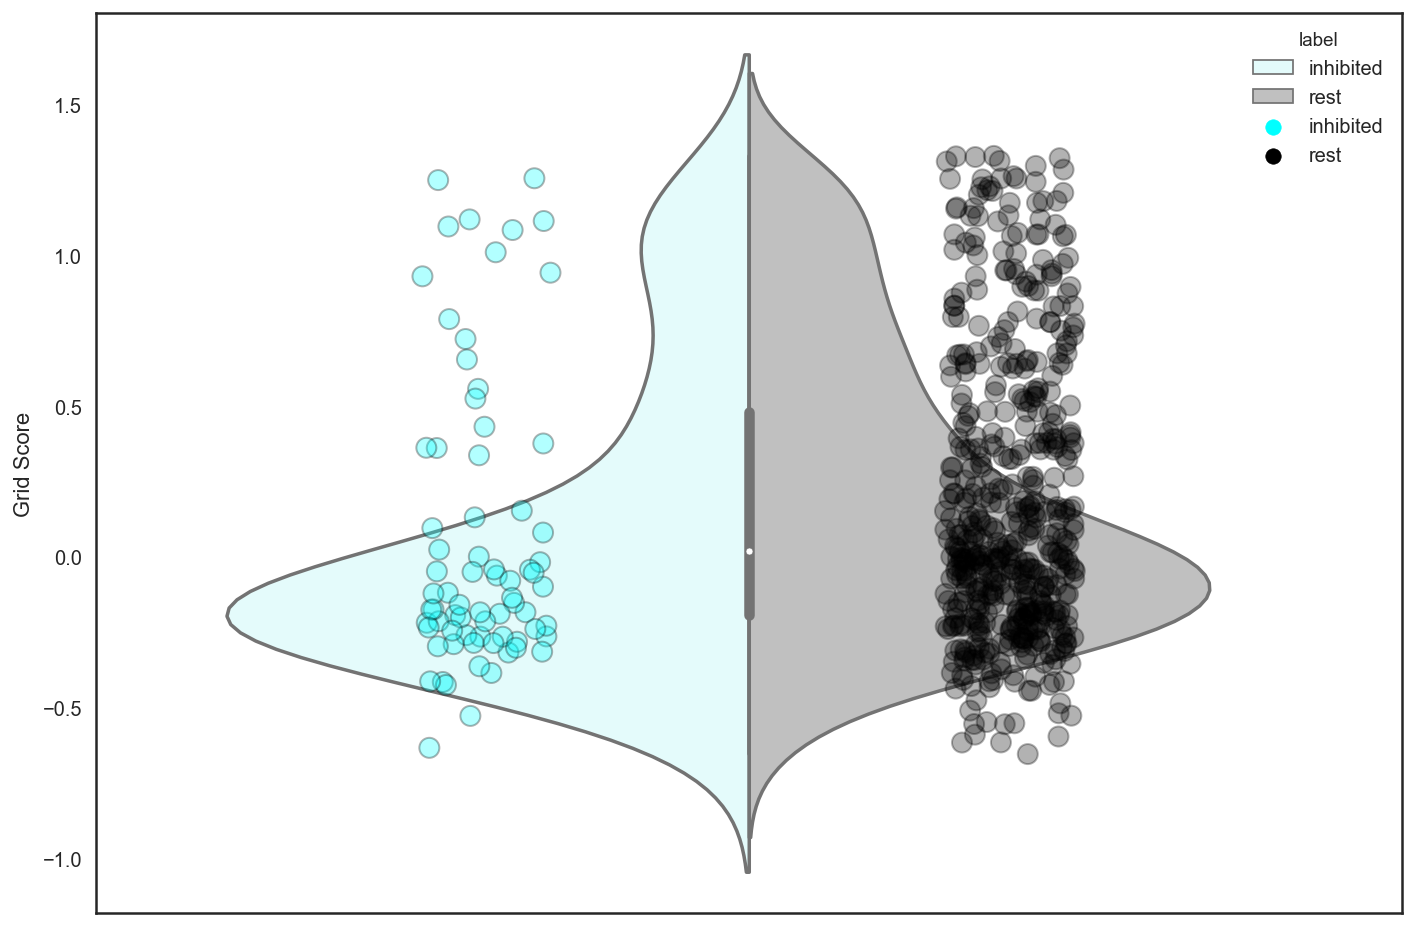

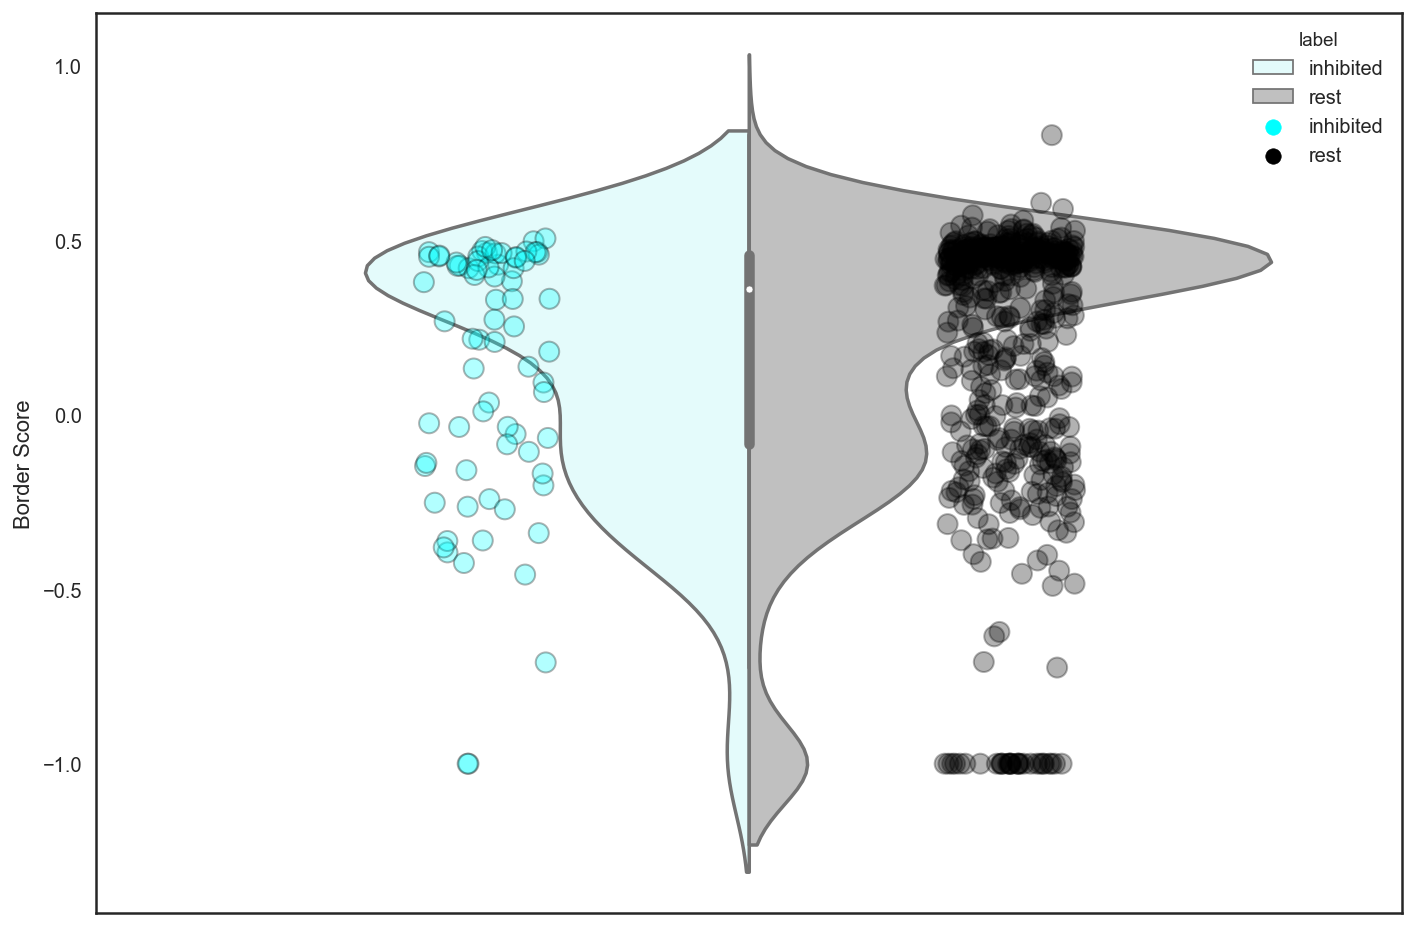

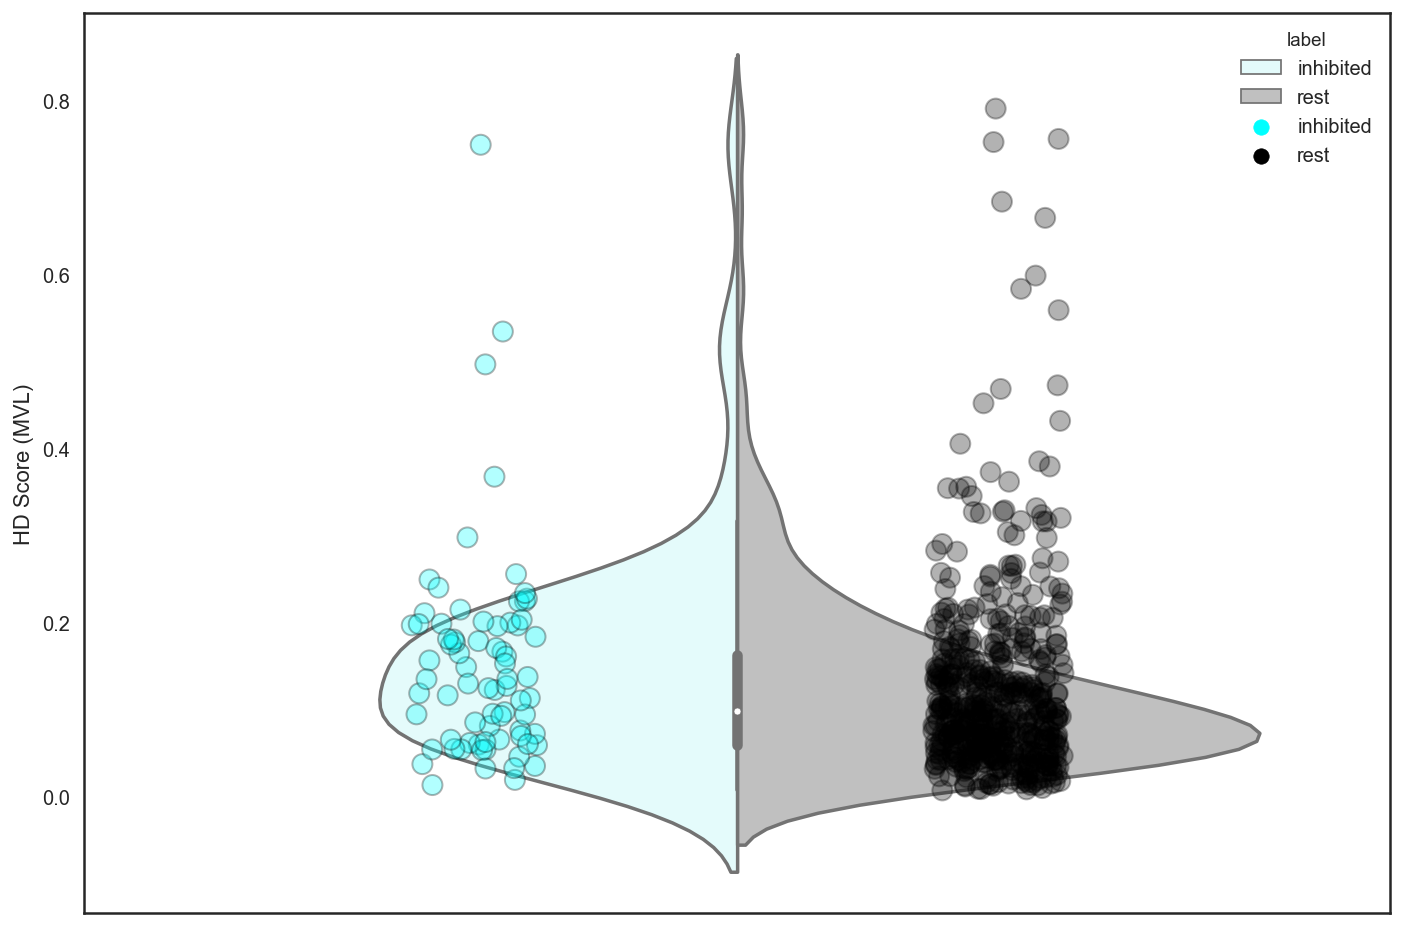

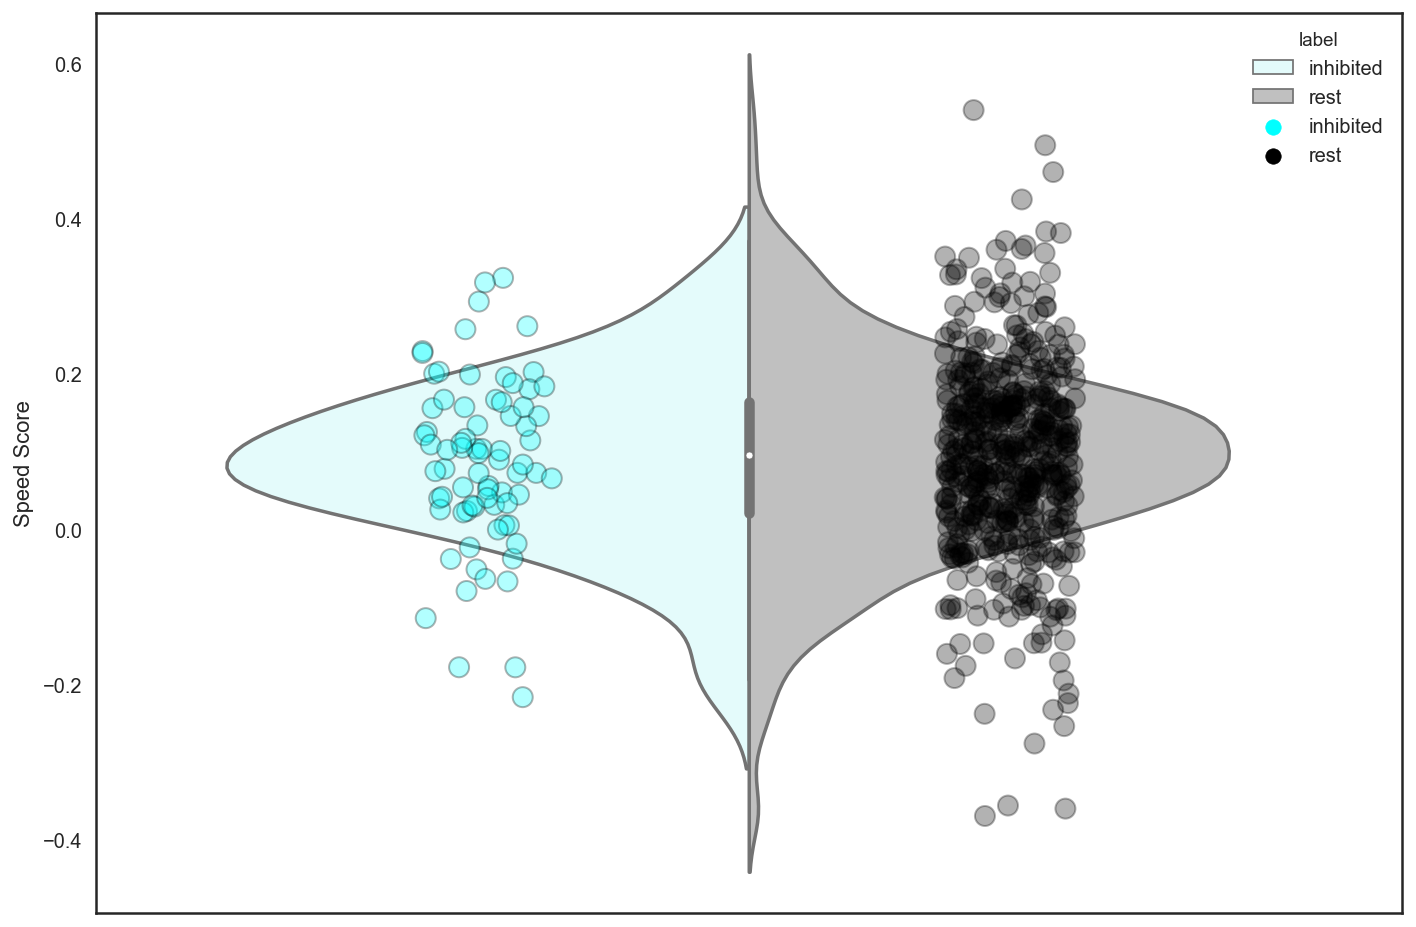

In [67]:
figure = plt.figure(facecolor='w')

sns.set(font_scale=1.)
sns.set_style('white')
 
    

figure.set_size_inches(11.7, 8.27)

sns.set_style("white")

arch_all["null"] = ""

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
#sns.palplot(sns.color_palette())

ax = sns.violinplot(x = arch_all["null"],y=arch_all.grid_score_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax = sns.stripplot(x = arch_all["null"],y=arch_all.grid_score_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
ax.set(xlabel='', ylabel='Grid Score')
#plt.savefig(r'N:\davidcr\stellate paper images\python output\grid_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.borderscore_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)

ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.borderscore_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3)
ax2.set(xlabel='', ylabel='Border Score')
#plt.savefig(r'N:\davidcr\stellate paper images\python output\border_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.tc_stats_mvl_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.tc_stats_mvl_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10,linewidth=1,alpha = 0.3 )
ax2.set(xlabel='', ylabel='HD Score (MVL)')
#plt.savefig(r'N:\davidcr\stellate paper images\python output\HD_score_violin.svg', format='svg', dpi=1000)


figure = plt.figure(facecolor='w')
sns.set(font_scale=1.)
figure.set_size_inches(11.7, 8.27)
sns.set_style("white")

taggedCM = ["#e0ffff", "#C0C0C0"]
sns.set_palette(taggedCM)
ax2 = sns.violinplot(x = arch_all["null"],y=arch_all.speedscore_bnt.astype(float) , hue = arch_all.label,split = True, alpha = 0.1)
taggedCM2 = ["#00ffff", "#000000"]
sns.set_palette(taggedCM2)
ax2 = sns.stripplot(x = arch_all["null"],y=arch_all.speedscore_bnt.astype(float) , hue = arch_all.label,jitter = True, dodge = True, size=10, linewidth=1, alpha = 0.3)
ax2.set(xlabel='', ylabel='Speed Score')
#plt.savefig(r'N:\davidcr\stellate paper images\python output\speed_score_violin.svg', format='svg', dpi=1000)



## Now check classifier perfomance on tagged cells (related to figure S4)

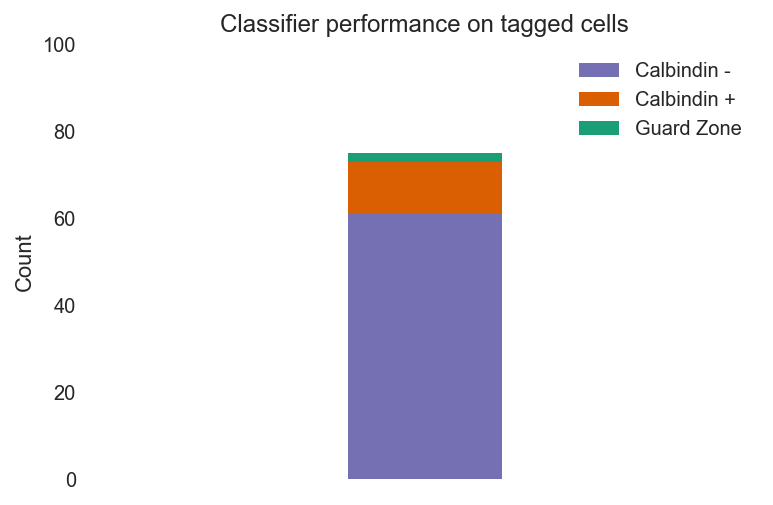

12
2
61
75


In [68]:
# retrieve tagged cells again
cells = arch_all[(arch_all.label == 'inhibited')].copy()
# get 3 different sets: 
figure.set_size_inches(11.7, 8.27)
calbindin = cells[(cells.calbindin_bnt == 1)&(np.fabs(cells.calbindin_dist_bnt_single)>=0.1)]
stellate = cells[(cells.calbindin_bnt == 0)&(np.fabs(cells.calbindin_dist_bnt_single)>=0.1)]
rest =cells[np.fabs(cells.calbindin_dist_bnt_single)<0.1]
cb = len(calbindin)
st = len(stellate)
r = len(rest)
width = 0.23
ind = 1
p1 = plt.bar(ind, st, width, color='#7570b3')
p2 = plt.bar(ind, cb, width, color='#d95f02', bottom=st)
p3 = plt.bar(ind, r,width,color='#1b9e77',bottom=[cb+st])


plt.gca().get_xaxis().set_ticks([])

plt.legend((p1[0], p2[0],p3[0]), ('Calbindin -', 'Calbindin +', 'Guard Zone'))
plt.ylim(0,100)
plt.xlim(0.5,1.5)
plt.title('Classifier performance on tagged cells')
plt.ylabel('Count')
sns.despine(left=True,bottom=True)
plt.savefig(r'N:\davidcr\stellate paper images\python output\tagged_classifier.svg', format='svg', dpi=1000)
plt.show()
print(len(calbindin))
print(len(rest))
print(len(stellate))
print(len(cells))


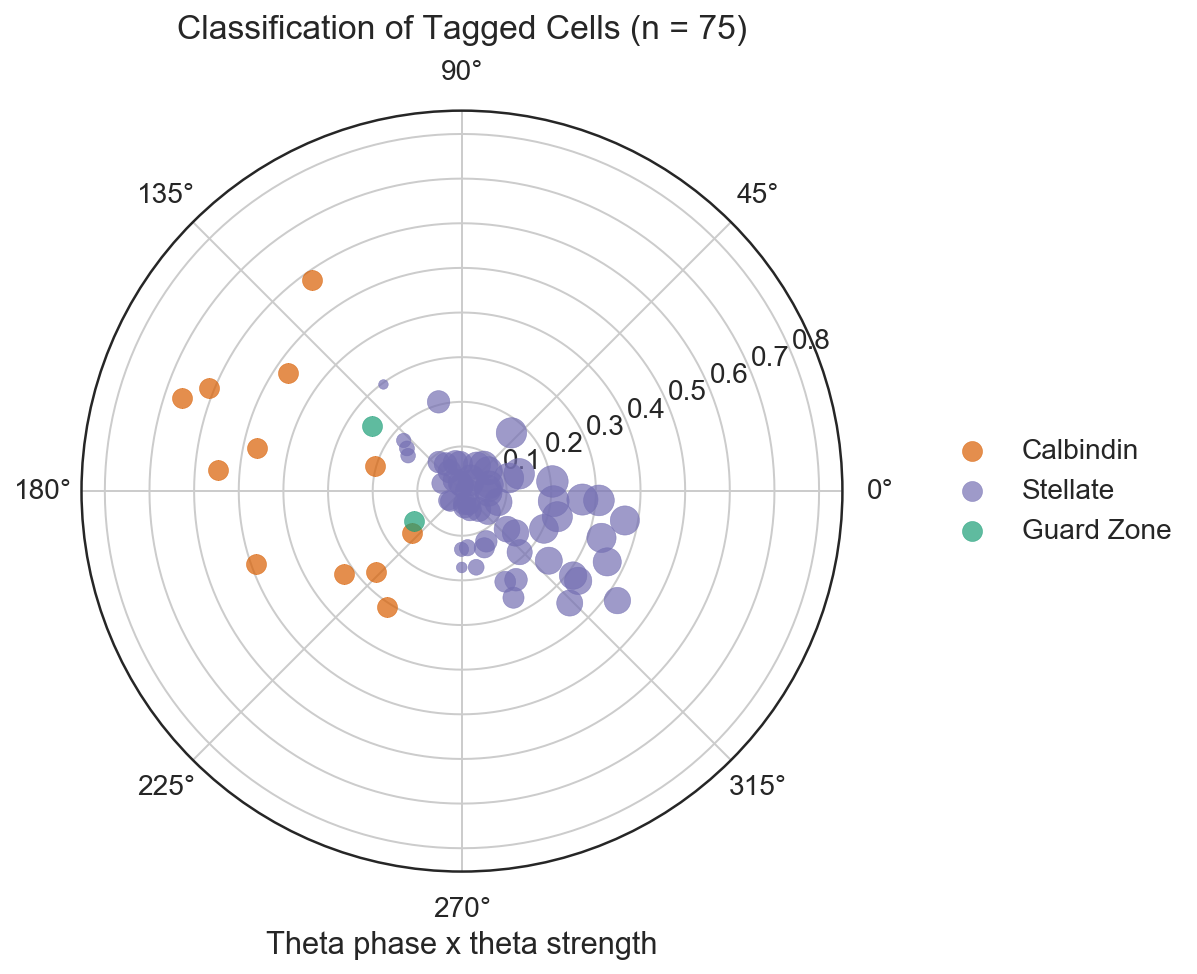

In [69]:
sns.set(font_scale=1.4,style='white')
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin',s = 100)
ax.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate',s=(stellate.calbindin_dist_bnt_single*200).astype(int))
ax.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label='Guard Zone', s = 100)
ax.set_xlabel('Theta phase x theta strength')
plt.title('Classification of Tagged Cells (n = 75)',  y=1.08)
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig(r'N:\davidcr\stellate paper images\python output\circular phase vs strength all tagged.svg', format='svg', dpi=1000, bbox_inches='tight')

plt.show()

C:\Users\davidcr\AppData\Local\Continuum\Miniconda2\envs\ms\lib\site-packages\matplotlib\collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


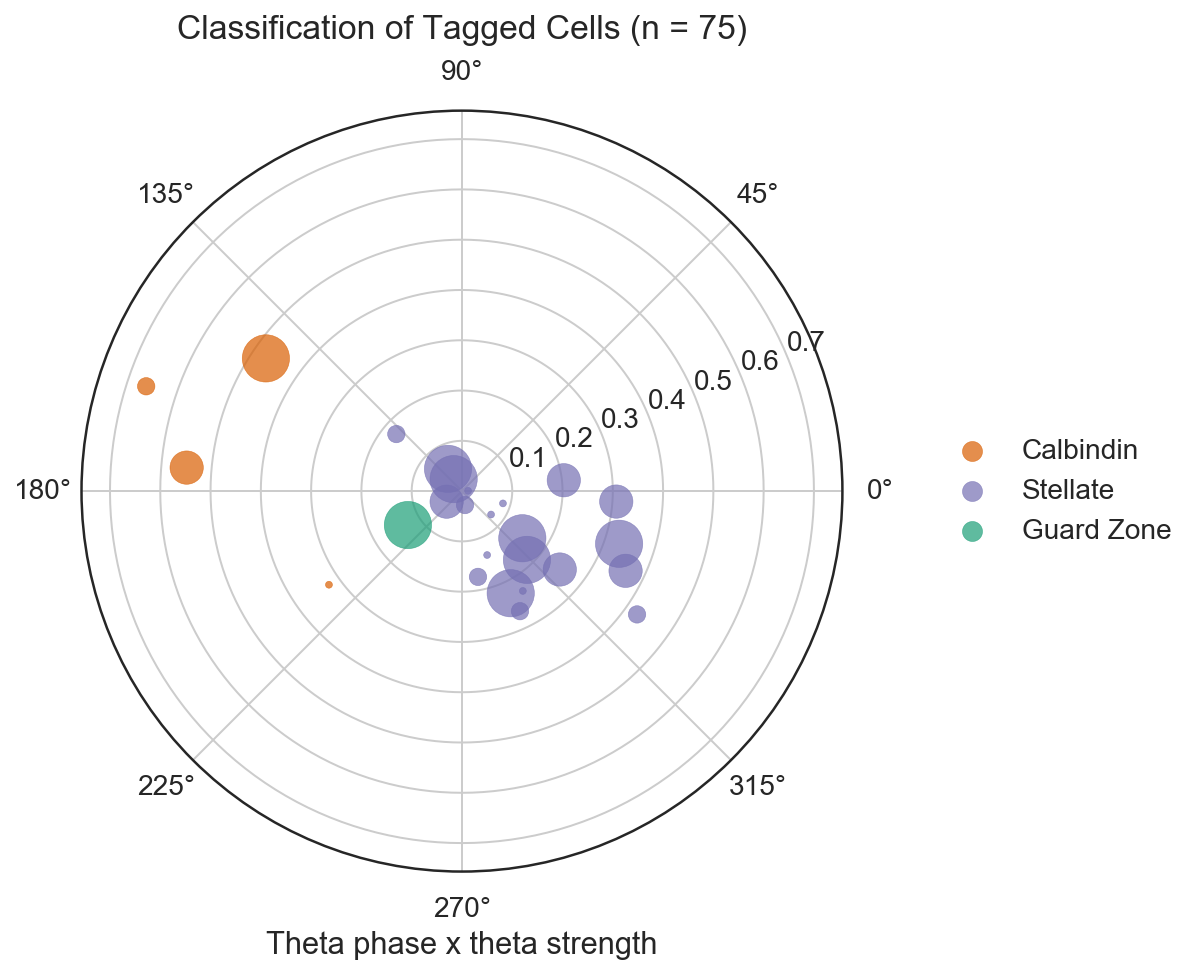

In [70]:
sns.set(font_scale=1.4,style='white')
figure = plt.figure(figsize=(15,7))
ax = figure.add_subplot(1,2,1,projection='polar')
ax.scatter(calbindin.theta_mean_phase_bnt_single.values.astype(float),calbindin.theta_strength_bnt_single.values.astype(float),c='#d95f02',alpha=.7,label='Calbindin',s=(calbindin.grid_score_bnt*500).astype(int))
ax.scatter(stellate.theta_mean_phase_bnt_single.values.astype(float),stellate.theta_strength_bnt_single.values.astype(float),c='#7570b3',alpha=.7,label='Stellate',s=(calbindin.grid_score_bnt*500).astype(int))
ax.scatter(rest.theta_mean_phase_bnt_single.values.astype(float),rest.theta_strength_bnt_single.values.astype(float),c='#1b9e77',alpha=.7,label='Guard Zone', s=(calbindin.grid_score_bnt*500).astype(int))
ax.set_xlabel('Theta phase x theta strength')
plt.title('Classification of Tagged Cells (n = 75)',  y=1.08)
lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
lgnd.legendHandles[0]._sizes = [100]
lgnd.legendHandles[1]._sizes = [100]
lgnd.legendHandles[2]._sizes = [100]
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(r'N:\davidcr\stellate paper images\python output\circular phase vs strength by grid score.svg', format='svg', dpi=1000, bbox_inches='tight')

plt.show()

In [71]:
#test how far the cells were away from the decision boundary...the idea here is to get a quantitative measure of what you can see be eye: the cells aren't to the decision boundary and it is unlikely that the 
#results will change if 

np.mean(calbindin.calbindin_dist_bnt)

-0.86700856085175004